<a href="https://colab.research.google.com/github/nataliaespector/CEIA_TPs_Procesamiento_Lenguaje_Natural_1/blob/main/Espector_PLN_Desaf%C3%ADo_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Traductor
Ejemplo basado en [LINK](https://stackabuse.com/python-for-nlp-neural-machine-translation-with-seq2seq-in-keras/)

### Datos
El objeto es utilizar datos disponibles de Anki de traducciones de texto en diferentes idiomas. Se construirá un modelo traductor seq2seq utilizando encoder-decoder.\
[LINK](https://www.manythings.org/anki/)

In [1]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

In [2]:
cuda = torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
# torchsummar actualmente tiene un problema con las LSTM, por eso
# se utiliza torchinfo, un fork del proyecto original con el bug solucionado
!pip3 install torchinfo
from torchinfo import summary

In [4]:
import os
import platform

if os.access('torch_helpers.py', os.F_OK) is False:
    if platform.system() == 'Windows':
        !curl !wget https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py > torch_helpers.py
    else:
        !wget torch_helpers.py https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py

### 1 - Datos

In [5]:
# Descargar la carpeta de dataset

import os
if os.access('spa-eng', os.F_OK) is False:
    if os.access('spa-eng.zip', os.F_OK) is False:
        !curl -L -o 'spa-eng.zip' 'http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip'
    !unzip -q spa-eng.zip
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [6]:
# dataset_file

text_file = "./spa-eng/spa.txt"
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]

# Por limitaciones de RAM no se leen todas las filas
MAX_NUM_SENTENCES = 60000

# Mezclar el dataset, forzar semilla siempre igual
np.random.seed([40])
np.random.shuffle(lines)

input_sentences = []
output_sentences = []
output_sentences_inputs = []
count = 0

for line in lines:
    count += 1
    if count > MAX_NUM_SENTENCES:
        break

    if '\t' not in line:
        continue

    # Input sentence --> eng
    # output --> spa
    input_sentence, output = line.rstrip().split('\t')

    # output sentence (decoder_output) tiene <eos>
    output_sentence = output + ' <eos>'
    # output sentence input (decoder_input) tiene <sos>
    output_sentence_input = '<sos> ' + output

    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows disponibles:", len(lines))
print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows disponibles: 118964
Cantidad de rows utilizadas: 60000


In [7]:
input_sentences[0], output_sentences[0], output_sentences_inputs[0]

('A deal is a deal.',
 'Un trato es un trato. <eos>',
 '<sos> Un trato es un trato.')

### 2 - Preprocesamiento

In [8]:
# Definir el tamaño máximo del vocabulario
MAX_VOCAB_SIZE = 15000

In [9]:
# Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# - num_words --> the maximum number of words to keep, based on word frequency.
# - Only the most common num_words-1 words will be kept.

# tokenizador de inglés
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de entrada más larga:", max_input_len)

Palabras en el vocabulario: 10692
Sentencia de entrada más larga: 47


In [10]:
# A los filtros de símbolos del Tokenizer agregamos el "¿",
# sacamos los "<>" para que no afectar nuestros tokens
# tokenizador de español
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_outputs))

num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE) # Se suma 1 por el primer <sos>
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Sentencia de salida más larga:", max_out_len)

Palabras en el vocabulario: 19614
Sentencia de salida más larga: 48


Como era de esperarse, las sentencias en castellano son más largas que en inglés, y lo mismo sucede con su vocabulario.

In [11]:
# Por una cuestion de que no explote la RAM se limitará el tamaño de las sentencias de entrada
# a la mitad:
max_input_len = 47
max_out_len = 50

A la hora de realizar padding es importante tener en cuenta que en el encoder los ceros se agregan al comienzo y en el decoder al final. Esto es porque la salida del encoder está basado en las últimas palabras de la sentencia (son las más importantes), mientras que en el decoder está basado en el comienzo de la secuencia de salida ya que es la realimentación del sistema y termina con fin de sentencia.

In [12]:
#from torch_helpers import pad_sequences
print("Cantidad de rows del dataset:", len(input_integer_seq))

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

Cantidad de rows del dataset: 60000
encoder_input_sequences shape: (60000, 47)
decoder_input_sequences shape: (60000, 50)


In [13]:
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_output_sequences shape:", decoder_output_sequences.shape)

decoder_output_sequences shape: (60000, 50)


In [14]:
torch.from_numpy(decoder_output_sequences).shape

torch.Size([60000, 50])

In [15]:
class Data(Dataset):
    def __init__(self, encoder_input, decoder_input, decoder_output, pad_idx=0):
        # Entradas como índices (Long)
        self.encoder_inputs = torch.from_numpy(encoder_input.astype(np.int64))  # [N, Tenc]
        self.decoder_inputs = torch.from_numpy(decoder_input.astype(np.int64))  # [N, Tdec]

        # 🔧 SALIDA COMO ÍNDICES (¡sin one-hot!)
        # decoder_output ya viene como índices [N, Tdec]
        self.decoder_outputs = torch.from_numpy(decoder_output.astype(np.int64))  # [N, Tdec]
        self.pad_idx = pad_idx

        self.len = self.decoder_outputs.shape[0]

    def __getitem__(self, index):
        # Devolvemos todo como Long (índices)
        return (
            self.encoder_inputs[index].long(),
            self.decoder_inputs[index].long(),
            self.decoder_outputs[index].long()
        )

    def __len__(self):
        return self.len

In [16]:
data_set = Data(
    encoder_input_sequences,     # [N, Tenc] índices
    decoder_input_sequences,     # [N, Tdec] índices (con <sos> al principio)
    decoder_output_sequences,    # [N, Tdec] índices (próximo token)
    pad_idx=0
)

encoder_input_size = data_set.encoder_inputs.shape[1]
print("encoder_input_size:", encoder_input_size)

decoder_input_size = data_set.decoder_inputs.shape[1]
print("decoder_input_size:", decoder_input_size)

print("Output dim (vocab_out):", num_words_output)

torch.manual_seed(42)
valid_set_size = int(data_set.len * 0.2)
train_set_size = data_set.len - valid_set_size

train_set = torch.utils.data.Subset(data_set, range(train_set_size))
valid_set = torch.utils.data.Subset(data_set, range(train_set_size, data_set.len))

print("Tamaño train:", len(train_set))
print("Tamaño valid:", len(valid_set))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True,  pin_memory=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False, pin_memory=True)


encoder_input_size: 47
decoder_input_size: 50
Output dim (vocab_out): 15000
Tamaño train: 48000
Tamaño valid: 12000


### 3 - Preparar los embeddings

In [17]:
# Descargar los embeddings desde un google drive (es la forma más rápida)
# NOTA: No hay garantía de que estos links perduren, en caso de que no estén
# disponibles descargar de la página oficial como se explica en el siguiente bloque
import os
import gdown
if os.access('gloveembedding.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1wlDBOrxPq2-3htQ6ryVo7K1XnzLcfh4r&export=download'
    output = 'gloveembedding.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings gloveembedding.pkl ya están descargados")

Los embeddings gloveembedding.pkl ya están descargados


In [18]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [19]:
# Por una cuestion de RAM se utilizará los embeddings de Glove de dimension 50
model_embeddings = GloveEmbeddings()

In [20]:
# Crear la Embedding matrix de las secuencias
# en ingles

print('preparing embedding matrix...')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

# word_index provienen del tokenizer

nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:

        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 145


In [21]:
nb_words

10692

In [22]:
# Dimensión de los embeddings de la secuencia en ingles
embedding_matrix.shape

(10692, 50)

In [23]:
nb_words_needed = int(encoder_input_sequences.max()) + 1
if nb_words_needed > nb_words:
    rows_to_add = nb_words_needed - nb_words
    import numpy as np
    extra = np.zeros((rows_to_add, embed_dim), dtype=embedding_matrix.dtype)  # o randn*1e-3
    embedding_matrix = np.vstack([embedding_matrix, extra])
    nb_words = nb_words_needed


In [24]:
nb_words

10693

### 4 - Entrenar el modelo

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# ====== HYPERPARÁMETROS (mismos nombres que en Keras) ======
n_units = 128
# nb_words, embed_dim, embedding_matrix, max_input_len,
# num_words_output, max_out_len deben existir como en tu notebook.

# ====== INICIALIZACIONES "estilo Keras" ======
def glorot_uniform_(w):
    fan_in = w.size(1)
    fan_out = w.size(0) // 4  # por gate, pero usamos el total para el mismo límite
    # Usamos fan_in+fan_out como en Glorot; PyTorch concatena 4 gates en dim=0
    limit = math.sqrt(6.0 / (fan_in + fan_out))
    with torch.no_grad():
        w.uniform_(-limit, limit)

def orthogonal_per_gate_(w, hidden_size):
    # w shape: (4*hidden, hidden). Keras hace orthogonal por gate.
    with torch.no_grad():
        for g in range(4):
            start = g * hidden_size
            end = (g + 1) * hidden_size
            nn.init.orthogonal_(w[start:end, :])

def set_forget_bias_keras_(bias, hidden_size):
    # bias shape: (4*hidden,)
    # Keras pone forget gate bias = 1
    with torch.no_grad():
        bias.zero_()
        bias[hidden_size:2*hidden_size] = 1.0

# ====== LSTM con init estilo Keras y "single bias" ======
def keras_like_lstm_(lstm: nn.LSTM, input_size, hidden_size):
    assert lstm.input_size == input_size and lstm.hidden_size == hidden_size
    # Pesos entrada (W) -> glorot_uniform
    glorot_uniform_(lstm.weight_ih_l0)
    # Pesos recurrentes (U) -> orthogonal por gate
    orthogonal_per_gate_(lstm.weight_hh_l0, hidden_size)
    # Bias: usamos sólo bias_ih como "bias único" (como Keras)
    set_forget_bias_keras_(lstm.bias_ih_l0, hidden_size)
    with torch.no_grad():
        lstm.bias_hh_l0.zero_()
    lstm.bias_hh_l0.requires_grad = False  # no entrenable, emula "un solo bias"

class Encoder(nn.Module):
    def __init__(self, nb_words, embed_dim, embedding_matrix, n_units):
        super().__init__()
        self.embedding = nn.Embedding(nb_words, embed_dim, padding_idx=0)
        # cargar y congelar
        with torch.no_grad():
            self.embedding.weight.copy_(torch.from_numpy(embedding_matrix).to(self.embedding.weight.device))
        self.embedding.weight.requires_grad = False

        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=n_units,
            num_layers=1,
            batch_first=True,
            bias=True  # tendremos bias_ih entrenable y bias_hh congelado en 0
        )
        keras_like_lstm_(self.lstm, embed_dim, n_units)

    def forward(self, x):
        # x: [B, T_enc] (Long)
        x = self.embedding(x)           # [B, T_enc, E]
        out, (h, c) = self.lstm(x)      # h,c: [1, B, H]
        return (h, c)

class Decoder(nn.Module):
    def __init__(self, num_words_output, n_units, max_out_len):
        super().__init__()
        # En Keras: decoder Embedding output_dim = n_units
        self.embedding = nn.Embedding(num_words_output, n_units, padding_idx=0)

        self.lstm = nn.LSTM(
            input_size=n_units,     # <- igual a Keras
            hidden_size=n_units,
            num_layers=1,
            batch_first=True,
            bias=True
        )
        keras_like_lstm_(self.lstm, n_units, n_units)

        # Dense (time-distributed): misma capa compartida en todos los pasos
        self.fc = nn.Linear(n_units, num_words_output)

    def forward(self, y_in, state):
        # y_in: [B, T_dec] (Long), state = (h, c) del encoder
        y = self.embedding(y_in)            # [B, T_dec, H]
        out, (h, c) = self.lstm(y, state)   # out: [B, T_dec, H]
        logits = self.fc(out)               # [B, T_dec, V]
        return logits, (h, c)

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, encoder_inputs, decoder_inputs):
        state = self.encoder(encoder_inputs)
        logits, _ = self.decoder(decoder_inputs, state)
        # logits: [B, T_dec, V] (equivalente a salida del Dense en Keras)
        return logits

# ====== Construcción del modelo (mismos símbolos que en Keras) ======
# Supone que ya se tiene: nb_words, embed_dim, embedding_matrix, num_words_output, max_input_len, max_out_len.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = Encoder(nb_words, embed_dim, embedding_matrix, n_units)
decoder = Decoder(num_words_output, n_units, max_out_len)
model = Seq2Seq(encoder, decoder).to(device)

# ====== Ejemplo de "compilación" y pérdida (equivalente conceptual) ======
# En Keras se usaba 'categorical_crossentropy' con one-hot. En PyTorch:
# - usar CrossEntropyLoss sobre logits y targets como índices (sin softmax).
criterion = nn.CrossEntropyLoss()  # ignorá padding si usás 0
pad_idx = 0
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, eps=1e-7)

# ====== Ejemplo de forward ======
# encoder_inputs: LongTensor [B, T_enc], decoder_inputs: LongTensor [B, T_dec]
# logits = model(encoder_inputs, decoder_inputs)  # [B, T_dec, V]
# loss = criterion(logits.view(-1, num_words_output), target_indices.view(-1))
# loss.backward(); optimizer.step()

In [26]:
from torchinfo import summary

B = 2  # batch chico para el summary

# Tensores de ejemplo EN EL MISMO DEVICE DEL MODELO y con dtype=Long
dummy_enc = torch.randint(0, nb_words,        (B, max_input_len),  device=device, dtype=torch.long)
dummy_dec = torch.randint(0, num_words_output,(B, max_out_len),    device=device, dtype=torch.long)

# Para modelos con múltiples entradas, pasar una tupla en input_data
summary(model,
        input_data=(dummy_enc, dummy_dec),
        device=device,                 # fuerza a ejecutar en ese device
        depth=3,                       # opcional
        col_names=("input_size","output_size","num_params","trainable"))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
Seq2Seq                                  [2, 47]                   [2, 50, 15000]            --                        Partial
├─Encoder: 1-1                           [2, 47]                   [1, 2, 128]               --                        Partial
│    └─Embedding: 2-1                    [2, 47]                   [2, 47, 50]               (534,650)                 False
│    └─LSTM: 2-2                         [2, 47, 50]               [2, 47, 128]              92,160                    Partial
├─Decoder: 1-2                           [2, 50]                   [2, 50, 15000]            --                        Partial
│    └─Embedding: 2-3                    [2, 50]                   [2, 50, 128]              1,920,000                 True
│    └─LSTM: 2-4                         [2, 50, 128]              [2, 50, 128]              132,096              

In [28]:
def token_accuracy_incl_pad(logits, y_true):
    # logits: [B, T, V]; y_true: [B, T] (Long)
    pred = logits.argmax(dim=-1)     # [B, T]
    return (pred == y_true).float().mean()

In [29]:
def train(model, train_loader, valid_loader, optimizer, criterion, epochs=15, device=None,
          metric_fn=token_accuracy_incl_pad, print_per_epoch=True):
    if device is None:
        device = next(model.parameters()).device

    hist = {"loss": [], "accuracy": [], "val_loss": [], "val_accuracy": []}

    for epoch in range(epochs):
        # ===== TRAIN =====
        model.train()
        ep_loss = 0.0
        ep_acc  = 0.0
        for enc_in, dec_in, y_true in train_loader:
            enc_in = enc_in.to(device).long()
            dec_in = dec_in.to(device).long()
            y_true = y_true.to(device).long()

            optimizer.zero_grad()
            logits = model(enc_in, dec_in)      # [B, T, V]
            B, T, V = logits.shape
            loss = criterion(logits.reshape(B*T, V), y_true.reshape(B*T))
            loss.backward()
            optimizer.step()

            ep_loss += loss.item()
            ep_acc  += metric_fn(logits, y_true).item()

        ep_loss /= len(train_loader)
        ep_acc  /= len(train_loader)
        hist["loss"].append(ep_loss)
        hist["accuracy"].append(ep_acc)

        # ===== VALID =====
        model.eval()
        v_loss = 0.0
        v_acc  = 0.0
        with torch.no_grad():
            for enc_in, dec_in, y_true in valid_loader:
                enc_in = enc_in.to(device).long()
                dec_in = dec_in.to(device).long()
                y_true = y_true.to(device).long()

                logits = model(enc_in, dec_in)
                B, T, V = logits.shape
                loss = criterion(logits.reshape(B*T, V), y_true.reshape(B*T))

                v_loss += loss.item()
                v_acc  += metric_fn(logits, y_true).item()

        v_loss /= len(valid_loader)
        v_acc  /= len(valid_loader)
        hist["val_loss"].append(v_loss)
        hist["val_accuracy"].append(v_acc)

        if print_per_epoch:
            print(f"Epoch {epoch+1:03d}/{epochs} "
                  f"- Train loss {ep_loss:.4f} - Train acc {ep_acc:.4f} "
                  f"- Valid loss {v_loss:.4f} - Valid acc {v_acc:.4f}")

    return hist

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

history = train(
    model=model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    optimizer=optimizer,
    criterion=criterion,
    epochs=15,
    device=device
)

Epoch 001/15 - Train loss 0.8844 - Train acc 0.8827 - Valid loss 0.6626 - Valid acc 0.8967
Epoch 002/15 - Train loss 0.6269 - Train acc 0.8994 - Valid loss 0.5933 - Valid acc 0.9024
Epoch 003/15 - Train loss 0.5591 - Train acc 0.9046 - Valid loss 0.5589 - Valid acc 0.9059
Epoch 004/15 - Train loss 0.5121 - Train acc 0.9081 - Valid loss 0.5386 - Valid acc 0.9081
Epoch 005/15 - Train loss 0.4753 - Train acc 0.9109 - Valid loss 0.5269 - Valid acc 0.9096
Epoch 006/15 - Train loss 0.4448 - Train acc 0.9136 - Valid loss 0.5187 - Valid acc 0.9105
Epoch 007/15 - Train loss 0.4182 - Train acc 0.9162 - Valid loss 0.5137 - Valid acc 0.9111
Epoch 008/15 - Train loss 0.3952 - Train acc 0.9188 - Valid loss 0.5119 - Valid acc 0.9117
Epoch 009/15 - Train loss 0.3745 - Train acc 0.9215 - Valid loss 0.5107 - Valid acc 0.9123
Epoch 010/15 - Train loss 0.3561 - Train acc 0.9242 - Valid loss 0.5103 - Valid acc 0.9128
Epoch 011/15 - Train loss 0.3396 - Train acc 0.9267 - Valid loss 0.5108 - Valid acc 0.9130

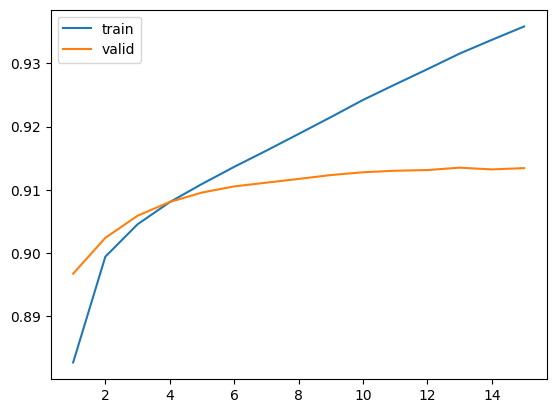

In [31]:
epoch_count = range(1, len(history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history['val_accuracy'], label='valid')
plt.show()

### 5 - Inferencia

In [32]:
'''
Step 1:
A deal is a deal -> Encoder -> enc(h1,c1)

enc(h1,c1) + <sos> -> Decoder -> Un + dec(h1,c1)

step 2:
dec(h1,c1) + Un -> Decoder -> trato + dec(h2,c2)

step 3:
dec(h2,c2) + trato -> Decoder -> es + dec(h3,c3)

step 4:
dec(h3,c3) + es -> Decoder -> un + dec(h4,c4)

step 5:
dec(h4,c4) + un -> Decoder -> trato + dec(h5,c5)

step 6:
dec(h5,c5) + trato. -> Decoder -> <eos> + dec(h6,c6)
'''

'\nStep 1:\nA deal is a deal -> Encoder -> enc(h1,c1)\n\nenc(h1,c1) + <sos> -> Decoder -> Un + dec(h1,c1)\n\nstep 2:\ndec(h1,c1) + Un -> Decoder -> trato + dec(h2,c2)\n\nstep 3:\ndec(h2,c2) + trato -> Decoder -> es + dec(h3,c3)\n\nstep 4:\ndec(h3,c3) + es -> Decoder -> un + dec(h4,c4)\n\nstep 5:\ndec(h4,c4) + un -> Decoder -> trato + dec(h5,c5)\n\nstep 6:\ndec(h5,c5) + trato. -> Decoder -> <eos> + dec(h6,c6)\n'

In [33]:
# Armar los conversores de indice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [34]:
import torch
import numpy as np

def translate_sentence(input_seq, model, word2idx_outputs, idx2word_target, max_out_len, device):
    """
    input_seq: array/list/torch.Tensor con ids de la oración fuente [T_enc]
    model: tu Seq2Seq ya cargado en 'device'
    word2idx_outputs: dict con '<sos>' y '<eos>'
    idx2word_target: dict id->palabra del vocab de salida
    max_out_len: longitud máxima a decodificar
    device: torch.device
    """
    model.eval()
    sos = word2idx_outputs['<sos>']
    eos = word2idx_outputs['<eos>']

    # --- preparar encoder input [1, T_enc] como Long en device
    if isinstance(input_seq, np.ndarray):
        enc = torch.from_numpy(input_seq.astype(np.int64))
    else:
        enc = torch.as_tensor(input_seq, dtype=torch.long)
    if enc.dim() == 1:
        enc = enc.unsqueeze(0)  # [1, T_enc]
    enc = enc.to(device)

    with torch.no_grad():
        # estados iniciales del decoder
        prev_state = model.encoder(enc)                 # (h,c) con shapes [1, 1, H]

        # primer token de entrada al decoder: <sos>
        tgt = torch.tensor([[sos]], dtype=torch.long, device=device)  # [1,1]

        output_words = []
        for _ in range(max_out_len):
            logits, prev_state = model.decoder(tgt, prev_state)   # logits: [1, 1, V]

            # tomar el último paso temporal y argmax sobre vocab
            next_token = logits[:, -1, :].argmax(dim=-1)          # [1]
            idx = next_token.item()

            if idx == eos:
                break
            # opcional: ignorar PAD(0) y <sos> si aparecen
            if idx != 0 and idx != sos:
                # Check if the predicted index is in the vocabulary
                if idx in idx2word_target:
                    output_words.append(idx2word_target[idx])
                else:
                    # Handle cases where the predicted index is not in the vocabulary
                    output_words.append(f'[UNK:{idx}]') # Or some other indicator


            # realimentar el token predicho al decoder
            tgt = next_token.view(1, 1)                           # [1,1]

    return " ".join(output_words)

In [35]:
# ========= Ejemplo de traducción =========
input_test = "My mother say hi."
print('Input:', input_test)

# Tokenizar
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representación en vector de tokens de ids:", integer_seq_test)

# Padding a la longitud máxima del encoder
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

# Traducción
translation = translate_sentence(
    encoder_sequence_test,
    model,
    word2idx_outputs,
    idx2word_target,
    max_out_len,
    device
)

print('Response:', translation)

Input: My mother say hi.
Representación en vector de tokens de ids: [18, 206, 130, 2574]
Padding del vector: [[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0   18  206  130 2574]]
Response: mi madre se casó


In [36]:
# ========= Ejemplo de traducción =========
input_test = "I like dogs and cats."
print('Input:', input_test)

# Tokenizar
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representación en vector de tokens de ids:", integer_seq_test)

# Padding a la longitud máxima del encoder
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

# Traducción
translation = translate_sentence(
    encoder_sequence_test,
    model,
    word2idx_outputs,
    idx2word_target,
    max_out_len,
    device
)

print('Response:', translation)

Input: I like dogs and cats.
Representación en vector de tokens de ids: [2, 35, 575, 34, 791]
Padding del vector: [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   2  35 575  34 791]]
Response: me gusta el café


In [37]:
# ========= Ejemplo de traducción =========
input_test = "I wish you happy new year."
print('Input:', input_test)

# Tokenizar
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representación en vector de tokens de ids:", integer_seq_test)

# Padding a la longitud máxima del encoder
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

# Traducción
translation = translate_sentence(
    encoder_sequence_test,
    model,
    word2idx_outputs,
    idx2word_target,
    max_out_len,
    device
)

print('Response:', translation)

Input: I wish you happy new year.
Representación en vector de tokens de ids: [2, 311, 4, 191, 122, 232]
Padding del vector: [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   2 311   4 191 122 232]]
Response: si no te hubiera sabido nada


In [38]:
# ========= Ejemplo de traducción =========
input_test = "Today is a beautiful day."
print('Input:', input_test)

# Tokenizar
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representación en vector de tokens de ids:", integer_seq_test)

# Padding a la longitud máxima del encoder
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

# Traducción
translation = translate_sentence(
    encoder_sequence_test,
    model,
    word2idx_outputs,
    idx2word_target,
    max_out_len,
    device
)

print('Response:', translation)

Input: Today is a beautiful day.
Representación en vector de tokens de ids: [143, 7, 6, 248, 105]
Padding del vector: [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0 143   7   6 248 105]]
Response: tom es un día soleado


In [39]:
# ========= Ejemplo de traducción =========
input_test = "The sky is blue"
print('Input:', input_test)

# Tokenizar
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representación en vector de tokens de ids:", integer_seq_test)

# Padding a la longitud máxima del encoder
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

# Traducción
translation = translate_sentence(
    encoder_sequence_test,
    model,
    word2idx_outputs,
    idx2word_target,
    max_out_len,
    device
)

print('Response:', translation)

Input: The sky is blue
Representación en vector de tokens de ids: [1, 913, 7, 804]
Padding del vector: [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   1 913   7 804]]
Response: el cielo es muy larga


# Desafío 4

## 1 - Replicar el modelo en Pytorch

Se replicó en Pytorch el modelo provisto en Keras con los mismos parámetros, buscando obtener los mismos resultados. Se tomó como base el modelo en Keras, otro modelo provisto en clase en Pytorch, y se utilizó asistencia de un modelo de lenguaje para lograr la correspondencia entre ambos modelos.

Dado que las LSTM de Keras y Pytorch no son idénticas, fue necesario agregar algunas funciones (glorot uniform, orthogonal per gate, set bias) para luego definir Keras_like_LSTM, y así poder replicar el modelo de Keras.

Finalmente, utilizando los mismos parámetros, se logró alcanzar una arquitectura similar:

En Keras:

* Total params: 1,886,336
* Trainable params: 1,693,786
* Non-trainable params: 192,550


En Pytorch:
* Total params: 1,887,410
* Trainable params: 1,693,786
* Non-trainable params: 193,624

Al realizar el entrenamiento, se obtiene una accuracy en validación de 0.7153, mientras que en el modelo con Keras se alcanzaba un 0.7128. Con estos resultados, se considera que los modelos son suficientemente similares para continuar con el desarrollo del trabajo.

## 2 - Pruebas con el modelo en Pytorch

Se realizaron distintas pruebas modificando la cantidad de datos de entrenamiento, la cantidad de palabras en el vocabulario, los tamaños de secuencias de entrada y salida, y la cantidad de neuronas de las capas recurrentes.

En cada caso, se evaluó la accuracy de validación, y se realizó la traducción de 5 frases diferentes para evaluar el desempeño del modelo. Se eligieron frases cortas y con palabras comunes, que idealmente deberían traducirse correctamente. Las frases son:

* My mother say hi (frase de prueba del modelo original en Keras)
* I like dogs and cats
* I wish you happy new year
* Today is a beautiful day
* The sky is blue

Es importante destacar que los parámetros se fueron ajustando de manera gradual, ya que al liberarlos demasiado se obtuvieron problemas relacionados a la memoria y la ejecución fallaba. Para la realización de cada prueba sin problemas, fue necesario reiniciar todo el entorno de ejecución y comenzar desde cero.

En la tabla a continuación se muestra un resumen de los parámetros modificados y los resultados obtenidos en cada caso, sin incluir los casos que fallaron.

| N° prueba | MAX_NUM_SENTENCES | MAX_VOCAB_SIZE | max_input_len | max_output_len | n_units | Valid acc | My mother say hi             | I like dogs and cats                                    | i wish you happy new year                    | Today is a beautiful day             | The sky is blue                     |
|-----------|---------------------|----------------|---------------|---------------|---------|-----------|------------------------------|---------------------------------------------------------|---------------------------------------------|--------------------------------------|--------------------------------------|
| 1         | 6000               | 8000           | 16            | 18            | 128     | 0.7153    | ella se ha ido               | -                                                       | -                                           | -                                    | -                                    |
| 2         | 12000              | 8000           | 16            | 18            | 128     | 0.7306    | mi mamá me gusta            | me gusta el filete medianamente cocido                  | te traje aspirina                           | tom es un chico tímido              | la situación está sabrosa            |
| 3         | 36000              | 8000           | 16            | 18            | 128     | 0.7537    | mi madre se le olvidó el miedo de mary | me gustan los perros                             | ojalá hubieras guardado el nuevo            | tom es un hombre de negocios       | la situación está en llamas         |
| 4         | 36000              | 16000          | 16            | 18            | 128     | 0.7428    | mi madre tiene un minuto    | me gusta el café y azúcar                             | te quiero ayudarte                           | tom es un conductor veloz          | la verdad es que es                 |
| 5         | 36000              | 16000          | 32            | 36            | 128     | 0.8708    | mi madre me ha arañado      | me gusta el café                                      | no te voy a casa mañana                     | tom es un chico formal             | tom habla francés                   |
| 6         | 38000              | 16000          | 32            | 36            | 128     | 0.8725    | mi madre ha comenzado a casa| me gusta el café                                      | te quiero que te guste                       | tom es un buen trabajo            | el cielo está despejado            |
| 7         | 45000              | 16000          | 32            | 36            | 128     | 0.8741    | mary se le acercó          | me gustan las almendras que christie que no           | quiero que tú estabas aquí                   | tom es un chico tímido            | el cielo está despejado            |
| 8         | 50000              | 18000          | 47            | 48            | 128     | 0.9057    | mary se casó con él        | me gusta el café                                      | ayer no te habría dicho                      | tom es un buen médico             | el cielo está despejado            |
| 9         | 60000              | 18000          | 32            | 36            | 128     | 0.8777    | mi madre tiene que decir   | me gusta el café                                      | te ayudo con ustedes                         | tom es un buen atleta            | la historia es extraña            |
| 10        | 60000              | 18000          | 47            | 50            | 128     | 0.9122    | mi madre me ayudó         | me gusta el inglés y el alemán                       | te haré daño                                | tom es un chico astuto          | la historia es extraña            |
| 11        | 60000              | 15000          | 47            | 50            | 128     | 0.9134    | mi madre se casó         | me gusta el café                                      | si no te hubiera sabido nada                 | tom es un día soleado          | el cielo es muy larga            |
| 12        | 70000              | 15000          | 47            | 48            | 128     | 0.9104    | mi madre ha perdido      | me gusta el café                                      | te quiero que seas feliz                     | tom es un perro grande        | el cielo está despejado         |
| 13        | 60000              | 15000          | 47            | 48            | 64      | 0.9053    | mi hermano se está quemando | me gusta el café                                   | te esperaré aquí                              | tom es un buen trabajo       | tom se está quedando en boston |
| 14        | 60000              | 15000          | 47            | 48            | 256     | 0.9115    | mi madre me enseñó      | me gusta el café y el día                          | te deseo que no vayas                         | tom es un conductor veloz   | la situación es desagradable  |
| 15        | 60000              | 15000          | 47            | 48            | 512     | 0.9131    | mi madre puso su mano | me gusta el helado de chocolate                | te quiero su respeto                          | tom es un chico malo        | el cielo es azul               |


## 2a - Extender el entrenamiento a más datos y tamaños de secuencias mayores

Se aumentó gradualmente la cantidad de datos de entrada, el tamaño del vocabulario y el tamaño de las secuencias de entrada y de salida.

En todos los casos se observó que a mayor cantidad de datos y tamaño de secuencias, mayor accuracy de validación. Sin embargo, si se aumenta demasiado se obtienen problemas con la memoria y no se puede finalizar la ejecución, por lo que se fue aumentando de a un parámetro por vez.

Los mayores incrementos en accuracy se observaron al modificar el tamaño de las secuencias de entrada y salida.

Es importante destacar que se evaluó en conjunto la accuracy de validación y la traducción de las 5 frases, ya que en algunos casos la mejora en accuracy no se condice con una mejora en la traducción.

Esto ocurre entre las ejecuciones 4 y 5, donde se observa un incremento importante en accuracy, pero no una mejora en las traducciones. Por ejemplo, pasa de "me gusta el café y azúcar" a "me gusta el café", cuando la estructura de la frase incluye dos sustantivos ("i like dogs and cats"). En "i wish you happy new year", se había obtenido una frase que comenzaba con "te quiero" (más similar a un "te deseo feliz año nuevo"), y luego se obtiene una frase sin ninguna relación con la original ("no te voy a casa mañana").

En la prueba 6, por ejemplo, se obtuvo una accuracy muy similar a la prueba anterior y a la siguiente, pero se destaca por lograr buenos resultados en la traducción: "mi madre", "me gusta", "te quiero" y "el cielo está despejado".

En conjunto, los mejores resultados se obtuvieron en las ejecuciones 11 y 12, llevando al máximo posible (sin fallas) la cantidad de sentencias utilizadas y los tamaños de secuencias. Se obtiene una accuracy de validación mayor a 0.91 en ambos casos, y las mejores traducciones de las frases de prueba. La ejecución 11 se destaca ya que es la única vez que se obtiene "es un día soleado" para la frase 4, que suele fallar en el resto de las ejecuciones.

## 2b - Explorar el impacto de la cantidad de neuronas en las capas recurrentes

Una vez que se definieron la cantidad de sentencias, tamaño de vocabulario y tamaño de secuencias, se realizaron pruebas con 64, 128, 256 y 512 neuronas en las capas recurrentes, que pueden observarse en la tabla.

Si bien la accuracy de validación obtenida se relaciona directamente con la cantidad de neuronas, la diferencia en los valores es mínima, y no se traduce directamente en un mejor desempeño en las frases de prueba.

Al reducir el tamaño a 64 se observa que empeoran los resultados con las frases de prueba ("mi hermano", "tom se está quedando en boston"), pero al aumentar a 256 y 512 no se observa que la mejora sea sustancial. Esto probablemente se relaciona con que al tener más parámetros entrenables se debería aumentar la cantidad de datos de entrada, y esto no es posible por los límites de memoria.

Al modificar la cantidad de neuronas se observa que se modifican en la misma medida la cantidad de parámetros del modelo.

Por otro lado, a medida que se aumenta la cantidad de neuronas aumenta considerablemente el tiempo que lleva el entrenamiento. Sin embargo, se observa que la curva de accuracy de validación alcanza un valor estable más rápidamente, por lo que se podría reducir la cantidad de épocas para reducir el tiempo de entrenamiento.

Observando todos los resultados en conjunto y los tiempos de entrenamiento, se decidió conservar la cantidad de neuronas iniciales de 128.

## 2c - Mostrar 5 ejemplos de traducciones generadas

Se muestran los resultados en la tabla y en la sección "5 - Inferencia".